In [1]:
!pip install xgboost -q
!pip install folium -q
!pip install geopy -q
!pip install plotly -q

In [2]:
import pandas as pd
import numpy as np
import json
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb

# Clustering
from sklearn.cluster import KMeans

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Geospatial
from geopy.distance import geodesic

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [3]:
from google.colab import files
import os

print("Please upload your kaggle.json file...")
uploaded = files.upload()

# Create kaggle directory and move the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✓ Kaggle API configured successfully!")


Please upload your kaggle.json file...


Saving kaggle.json to kaggle.json
✓ Kaggle API configured successfully!


In [4]:
!kaggle datasets download -d crailtap/taxi-trajectory
!unzip -q taxi-trajectory.zip

print("✓ Dataset downloaded and extracted successfully!")
print("\nFiles in directory:")
!ls -lh *.csv

Dataset URL: https://www.kaggle.com/datasets/crailtap/taxi-trajectory
License(s): unknown
 97% 501M/515M [00:03<00:00, 119MB/s] 
100% 515M/515M [00:03<00:00, 168MB/s]
✓ Dataset downloaded and extracted successfully!

Files in directory:
-rw-r--r-- 1 root root 1.9G Sep 29  2019 train.csv


In [5]:
print("Loading dataset...")
# Load first 100k rows for faster processing (adjust as needed)
df = pd.read_csv('train.csv', nrows=100000)

print(f"✓ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("\n" + "="*80)
print("DATASET OVERVIEW")
print("="*80)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 3 rows:")
print(df.head(3))
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
print(df.describe())

Loading dataset...
✓ Dataset loaded: 100000 rows, 9 columns

DATASET OVERVIEW

Column Names:
['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'POLYLINE']

First 3 rows:
               TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
0  1372636858620000589         C          NaN           NaN  20000589   
1  1372637303620000596         B          NaN           7.0  20000596   
2  1372636951620000320         C          NaN           NaN  20000320   

    TIMESTAMP DAY_TYPE  MISSING_DATA  \
0  1372636858        A         False   
1  1372637303        A         False   
2  1372636951        A         False   

                                            POLYLINE  
0  [[-8.618643,41.141412],[-8.618499,41.141376],[...  
1  [[-8.639847,41.159826],[-8.640351,41.159871],[...  
2  [[-8.612964,41.140359],[-8.613378,41.14035],[-...  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data c

In [6]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two GPS coordinates using Haversine formula"""
    R = 6371  # Earth's radius in km

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c

    return distance

def calculate_route_distance(polyline):
    """Calculate total distance of a route from GPS coordinates"""
    if len(polyline) < 2:
        return 0

    total_distance = 0
    for i in range(len(polyline) - 1):
        lat1, lon1 = polyline[i]
        lat2, lon2 = polyline[i + 1]
        total_distance += haversine_distance(lat1, lon1, lat2, lon2)

    return total_distance

def calculate_bearing(lat1, lon1, lat2, lon2):
    """Calculate bearing between two points"""
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1

    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)

    initial_bearing = np.arctan2(x, y)
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

def extract_features_from_polyline(polyline):
    """Extract comprehensive features from GPS polyline"""
    if len(polyline) == 0:
        return {
            'start_lat': None, 'start_lon': None,
            'end_lat': None, 'end_lon': None,
            'num_points': 0, 'distance': 0,
            'bearing': None, 'straightness': 0
        }

    start_point = polyline[0]
    end_point = polyline[-1]

    # Calculate total distance
    total_distance = calculate_route_distance(polyline)

    # Calculate straight-line distance
    straight_distance = haversine_distance(
        start_point[0], start_point[1],
        end_point[0], end_point[1]
    )

    # Calculate straightness ratio (1 = straight line, 0 = very winding)
    straightness = straight_distance / total_distance if total_distance > 0 else 0

    # Calculate bearing
    bearing = calculate_bearing(
        start_point[0], start_point[1],
        end_point[0], end_point[1]
    )

    return {
        'start_lat': start_point[0],
        'start_lon': start_point[1],
        'end_lat': end_point[0],
        'end_lon': end_point[1],
        'num_points': len(polyline),
        'distance': total_distance,
        'bearing': bearing,
        'straightness': straightness
    }

print("✓ Helper functions defined successfully!")

✓ Helper functions defined successfully!


In [7]:
print(f"\nInitial dataset size: {df.shape[0]} rows")

# Remove rows with missing polyline
df = df[df['POLYLINE'].notna()].copy()
df = df[df['POLYLINE'] != '[]'].copy()

# Remove rows with missing data
df = df[df['MISSING_DATA'] == False].copy()

print(f"After removing missing data: {df.shape[0]} rows")

# Parse POLYLINE from string to list
print("\nParsing GPS coordinates...")
df['POLYLINE'] = df['POLYLINE'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# Filter out empty or very short trips (less than 2 points)
df = df[df['POLYLINE'].apply(lambda x: len(x) >= 2)].copy()

print(f"After filtering short trips: {df.shape[0]} rows")

# Convert timestamp to datetime and extract time features
print("\nExtracting temporal features...")
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit='s')
df['hour'] = df['TIMESTAMP'].dt.hour
df['day_of_week'] = df['TIMESTAMP'].dt.dayofweek
df['month'] = df['TIMESTAMP'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Define rush hours
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

print("✓ Data cleaned and preprocessed successfully!")

# ============================================================================
# CELL 8: Feature Engineering
# ============================================================================
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

print("\nExtracting features from GPS polylines...")
# Extract features from polyline
polyline_features = df['POLYLINE'].apply(extract_features_from_polyline)
polyline_df = pd.DataFrame(polyline_features.tolist())

# Merge with original dataframe
df = pd.concat([df, polyline_df], axis=1)

# Remove rows with invalid coordinates
df = df.dropna(subset=['start_lat', 'start_lon', 'end_lat', 'end_lon'])

print(f"Dataset size after feature extraction: {df.shape[0]} rows")

# Calculate trip duration in seconds (15 seconds per GPS point)
df['duration_seconds'] = df['num_points'] * 15

# Calculate average speed
df['avg_speed_kmh'] = df.apply(
    lambda row: (row['distance'] / row['duration_seconds']) * 3600 if row['duration_seconds'] > 0 else 0,
    axis=1
)

# Remove outliers (unrealistic speeds)
df = df[(df['avg_speed_kmh'] > 0) & (df['avg_speed_kmh'] < 150)]
df = df[df['distance'] > 0.1]  # Remove very short trips

print(f"After removing outliers: {df.shape[0]} rows")

print("\n✓ Feature engineering completed!")
print("\nNew Features Created:")
print("- start_lat, start_lon, end_lat, end_lon")
print("- num_points, distance, bearing, straightness")
print("- duration_seconds, avg_speed_kmh")
print("- hour, day_of_week, month, is_weekend, is_rush_hour")


Initial dataset size: 100000 rows
After removing missing data: 99633 rows

Parsing GPS coordinates...
After filtering short trips: 98445 rows

Extracting temporal features...
✓ Data cleaned and preprocessed successfully!

FEATURE ENGINEERING

Extracting features from GPS polylines...
Dataset size after feature extraction: 98445 rows
After removing outliers: 97446 rows

✓ Feature engineering completed!

New Features Created:
- start_lat, start_lon, end_lat, end_lon
- num_points, distance, bearing, straightness
- duration_seconds, avg_speed_kmh
- hour, day_of_week, month, is_weekend, is_rush_hour


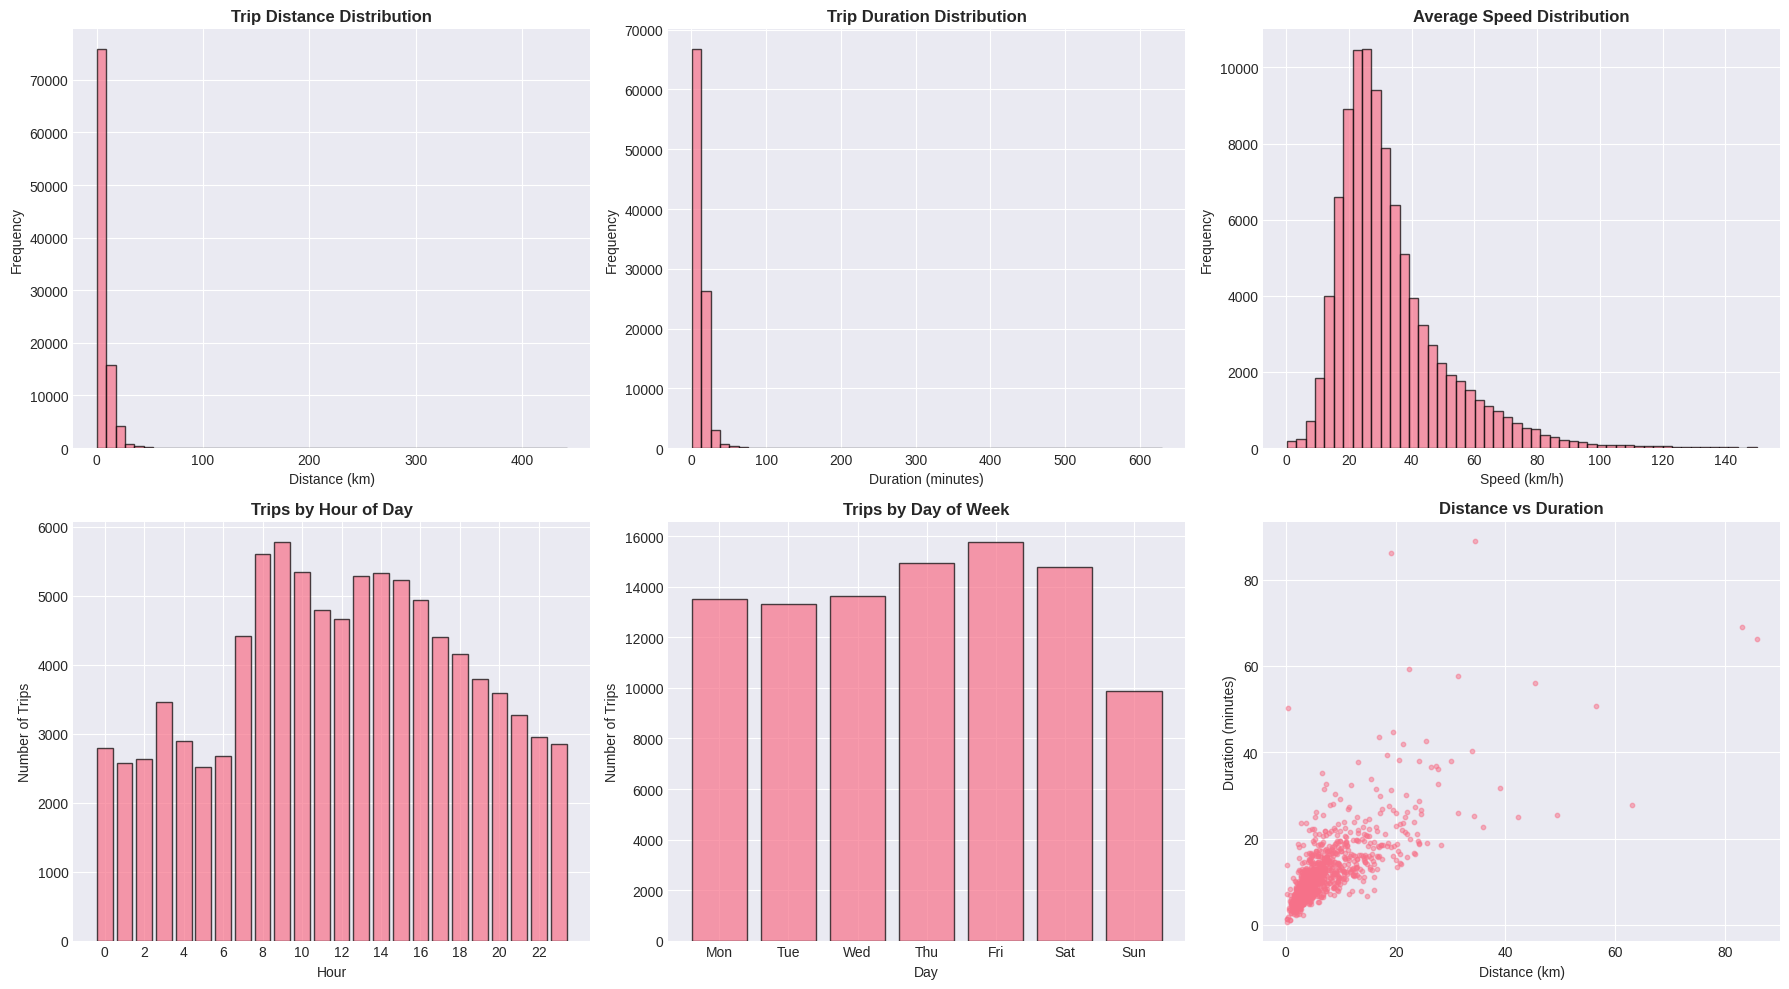


✓ Exploratory Data Analysis completed!


In [8]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Distance distribution
axes[0, 0].hist(df['distance'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Trip Distance Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Distance (km)')
axes[0, 0].set_ylabel('Frequency')

# 2. Duration distribution
axes[0, 1].hist(df['duration_seconds']/60, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Trip Duration Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Duration (minutes)')
axes[0, 1].set_ylabel('Frequency')

# 3. Speed distribution
axes[0, 2].hist(df['avg_speed_kmh'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Average Speed Distribution', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Speed (km/h)')
axes[0, 2].set_ylabel('Frequency')

# 4. Trips by hour
hour_counts = df['hour'].value_counts().sort_index()
axes[1, 0].bar(hour_counts.index, hour_counts.values, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Trips by Hour of Day', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Number of Trips')
axes[1, 0].set_xticks(range(0, 24, 2))

# 5. Trips by day of week
day_counts = df['day_of_week'].value_counts().sort_index()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 1].bar(range(7), [day_counts.get(i, 0) for i in range(7)], edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Trips by Day of Week', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Day')
axes[1, 1].set_ylabel('Number of Trips')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(day_names)

# 6. Distance vs Duration scatter
sample = df.sample(min(1000, len(df)))
axes[1, 2].scatter(sample['distance'], sample['duration_seconds']/60, alpha=0.5, s=10)
axes[1, 2].set_title('Distance vs Duration', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Distance (km)')
axes[1, 2].set_ylabel('Duration (minutes)')

plt.tight_layout()
plt.show()

print("\n✓ Exploratory Data Analysis completed!")


K-MEANS CLUSTERING FOR FREQUENT ZONES

Performing K-Means clustering with 10 clusters...
✓ Clustering completed!


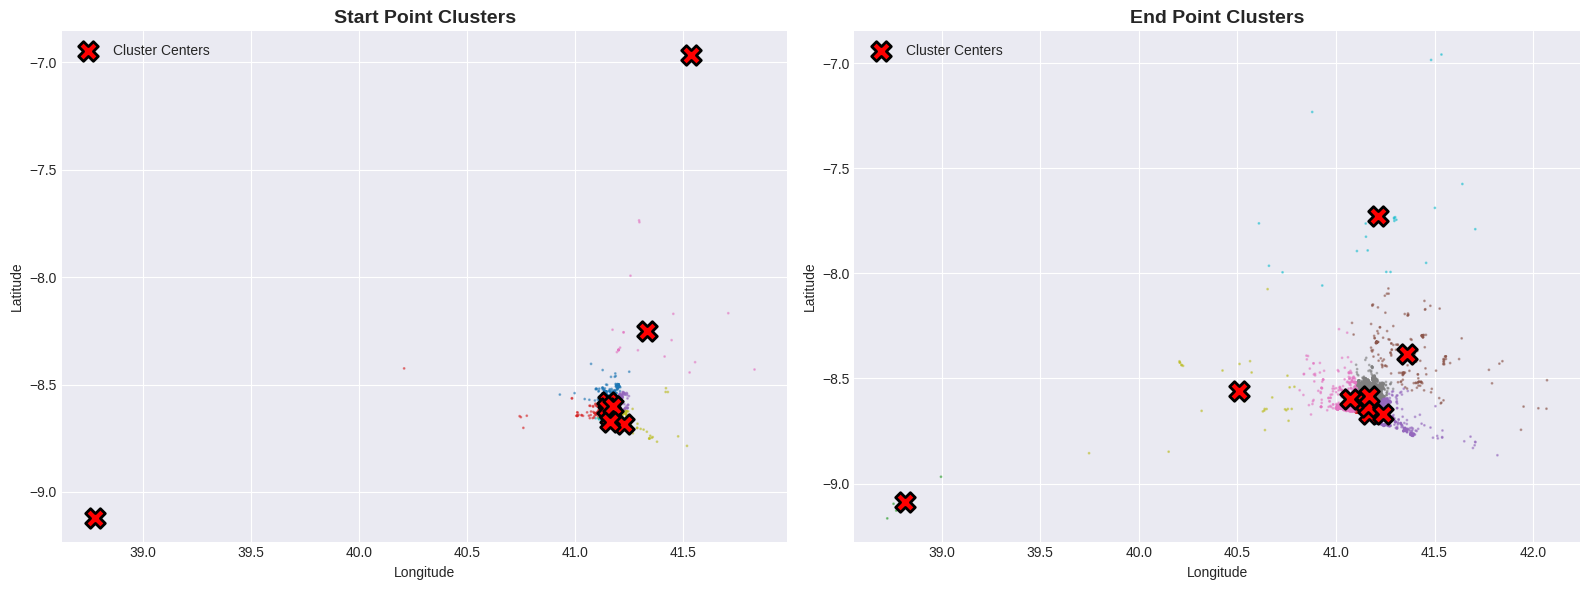


✓ Identified 10 frequent zones for pickup and dropoff locations


In [9]:
print("\n" + "="*80)
print("K-MEANS CLUSTERING FOR FREQUENT ZONES")
print("="*80)

# Prepare data for clustering (start and end points)
clustering_data = df[['start_lat', 'start_lon', 'end_lat', 'end_lon']].copy()

# Perform K-Means clustering
n_clusters = 10
print(f"\nPerforming K-Means clustering with {n_clusters} clusters...")

kmeans_start = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_end = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

df['start_cluster'] = kmeans_start.fit_predict(df[['start_lat', 'start_lon']])
df['end_cluster'] = kmeans_end.fit_predict(df[['end_lat', 'end_lon']])

print("✓ Clustering completed!")

# Visualize clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Start clusters
scatter1 = axes[0].scatter(df['start_lon'], df['start_lat'],
                           c=df['start_cluster'], cmap='tab10',
                           alpha=0.5, s=1)
axes[0].scatter(kmeans_start.cluster_centers_[:, 1],
               kmeans_start.cluster_centers_[:, 0],
               c='red', marker='X', s=200, edgecolors='black', linewidths=2,
               label='Cluster Centers')
axes[0].set_title('Start Point Clusters', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].legend()

# End clusters
scatter2 = axes[1].scatter(df['end_lon'], df['end_lat'],
                          c=df['end_cluster'], cmap='tab10',
                          alpha=0.5, s=1)
axes[1].scatter(kmeans_end.cluster_centers_[:, 1],
               kmeans_end.cluster_centers_[:, 0],
               c='red', marker='X', s=200, edgecolors='black', linewidths=2,
               label='Cluster Centers')
axes[1].set_title('End Point Clusters', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n✓ Identified {n_clusters} frequent zones for pickup and dropoff locations")

In [10]:
feature_columns = [
    'start_lat', 'start_lon', 'end_lat', 'end_lon',
    'distance', 'bearing', 'straightness', 'num_points',
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour',
    'start_cluster', 'end_cluster'
]

target_column = 'duration_seconds'

# Create feature matrix and target vector
X = df[feature_columns].copy()
y = df[target_column].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Check for any remaining missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum()}")

# Remove any rows with missing values
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\nFinal dataset size: {X.shape[0]} samples")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data preparation completed!")



Feature matrix shape: (97446, 15)
Target vector shape: (97446,)

Missing values in features: 7545
Missing values in target: 0

Final dataset size: 95937 samples

Training set: 76749 samples
Testing set: 19188 samples

✓ Data preparation completed!


In [11]:
print("\nTraining Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)

# Make predictions
print("\nMaking predictions...")
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

# Calculate metrics
print("\n" + "="*60)
print("RANDOM FOREST MODEL PERFORMANCE")
print("="*60)

# Training metrics
mae_train_rf = mean_absolute_error(y_train, y_pred_rf_train)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
r2_train_rf = r2_score(y_train, y_pred_rf_train)

print("\nTraining Set Metrics:")
print(f"  MAE:  {mae_train_rf:.2f} seconds ({mae_train_rf/60:.2f} minutes)")
print(f"  RMSE: {rmse_train_rf:.2f} seconds ({rmse_train_rf/60:.2f} minutes)")
print(f"  R² Score: {r2_train_rf:.4f}")

# Testing metrics
mae_test_rf = mean_absolute_error(y_test, y_pred_rf_test)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
r2_test_rf = r2_score(y_test, y_pred_rf_test)

print("\nTesting Set Metrics:")
print(f"  MAE:  {mae_test_rf:.2f} seconds ({mae_test_rf/60:.2f} minutes)")
print(f"  RMSE: {rmse_test_rf:.2f} seconds ({rmse_test_rf/60:.2f} minutes)")
print(f"  R² Score: {r2_test_rf:.4f}")

print("\n✓ Random Forest training completed!")


Training Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s



Making predictions...

RANDOM FOREST MODEL PERFORMANCE

Training Set Metrics:
  MAE:  0.58 seconds (0.01 minutes)
  RMSE: 50.54 seconds (0.84 minutes)
  R² Score: 0.9941

Testing Set Metrics:
  MAE:  0.64 seconds (0.01 minutes)
  RMSE: 47.49 seconds (0.79 minutes)
  R² Score: 0.9948

✓ Random Forest training completed!


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [12]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

xgb_model.fit(X_train, y_train)

# Make predictions
print("\nMaking predictions...")
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

# Calculate metrics
print("\n" + "="*60)
print("XGBOOST MODEL PERFORMANCE")
print("="*60)

# Training metrics
mae_train_xgb = mean_absolute_error(y_train, y_pred_xgb_train)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb_train))
r2_train_xgb = r2_score(y_train, y_pred_xgb_train)

print("\nTraining Set Metrics:")
print(f"  MAE:  {mae_train_xgb:.2f} seconds ({mae_train_xgb/60:.2f} minutes)")
print(f"  RMSE: {rmse_train_xgb:.2f} seconds ({rmse_train_xgb/60:.2f} minutes)")
print(f"  R² Score: {r2_train_xgb:.4f}")

# Testing metrics
mae_test_xgb = mean_absolute_error(y_test, y_pred_xgb_test)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb_test))
r2_test_xgb = r2_score(y_test, y_pred_xgb_test)

print("\nTesting Set Metrics:")
print(f"  MAE:  {mae_test_xgb:.2f} seconds ({mae_test_xgb/60:.2f} minutes)")
print(f"  RMSE: {rmse_test_xgb:.2f} seconds ({rmse_test_xgb/60:.2f} minutes)")
print(f"  R² Score: {r2_test_xgb:.4f}")

print("\n✓ XGBoost training completed!")



Making predictions...

XGBOOST MODEL PERFORMANCE

Training Set Metrics:
  MAE:  3.54 seconds (0.06 minutes)
  RMSE: 9.45 seconds (0.16 minutes)
  R² Score: 0.9998

Testing Set Metrics:
  MAE:  17.14 seconds (0.29 minutes)
  RMSE: 301.09 seconds (5.02 minutes)
  R² Score: 0.7921

✓ XGBoost training completed!



         Model  Train MAE (min)  Test MAE (min)  Train RMSE (min)  Test RMSE (min)  Train R²  Test R²
Random Forest         0.009680        0.010636          0.842268         0.791530  0.994123 0.994829
      XGBoost         0.058926        0.285622          0.157513         5.018173  0.999794 0.792149

✓ Best Model: Random Forest


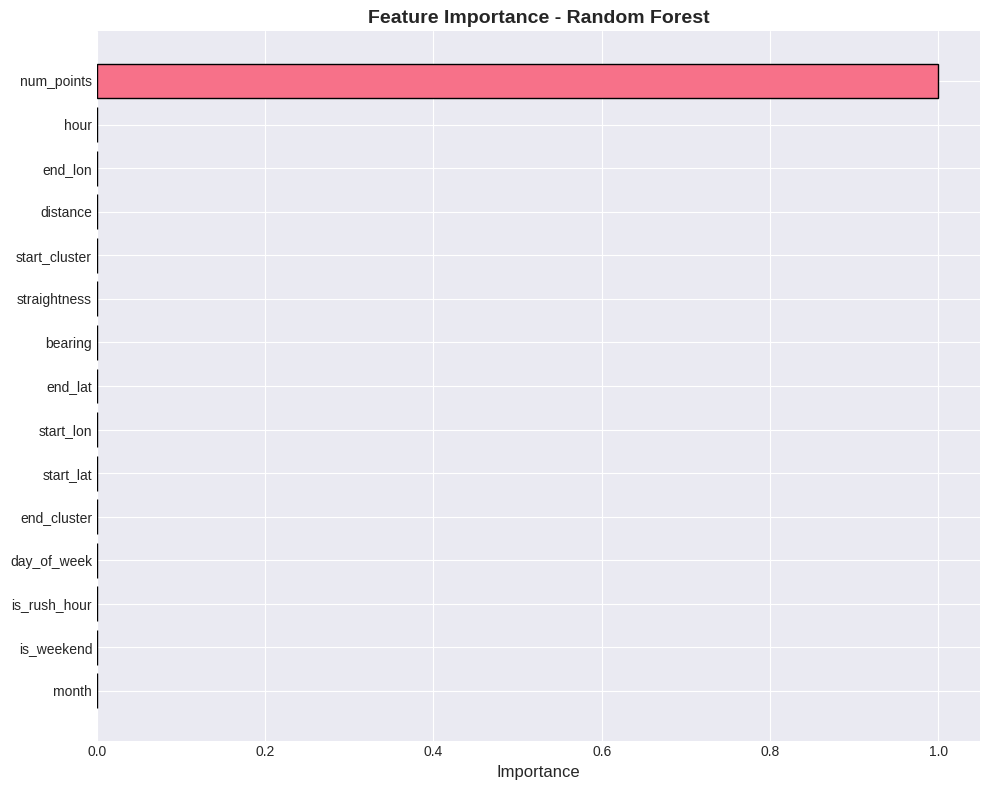


✓ Model comparison completed!


In [13]:
comparison_data = {
    'Model': ['Random Forest', 'XGBoost'],
    'Train MAE (min)': [mae_train_rf/60, mae_train_xgb/60],
    'Test MAE (min)': [mae_test_rf/60, mae_test_xgb/60],
    'Train RMSE (min)': [rmse_train_rf/60, rmse_train_xgb/60],
    'Test RMSE (min)': [rmse_test_rf/60, rmse_test_xgb/60],
    'Train R²': [r2_train_rf, r2_train_xgb],
    'Test R²': [r2_test_rf, r2_test_xgb]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Select best model
if mae_test_xgb < mae_test_rf:
    best_model = xgb_model
    best_model_name = 'XGBoost'
    feature_importance = xgb_model.feature_importances_
else:
    best_model = rf_model
    best_model_name = 'Random Forest'
    feature_importance = rf_model.feature_importances_

print(f"\n✓ Best Model: {best_model_name}")

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
feature_imp_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)

ax.barh(feature_imp_df['Feature'], feature_imp_df['Importance'], edgecolor='black')
ax.set_xlabel('Importance', fontsize=12)
ax.set_title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Model comparison completed!")

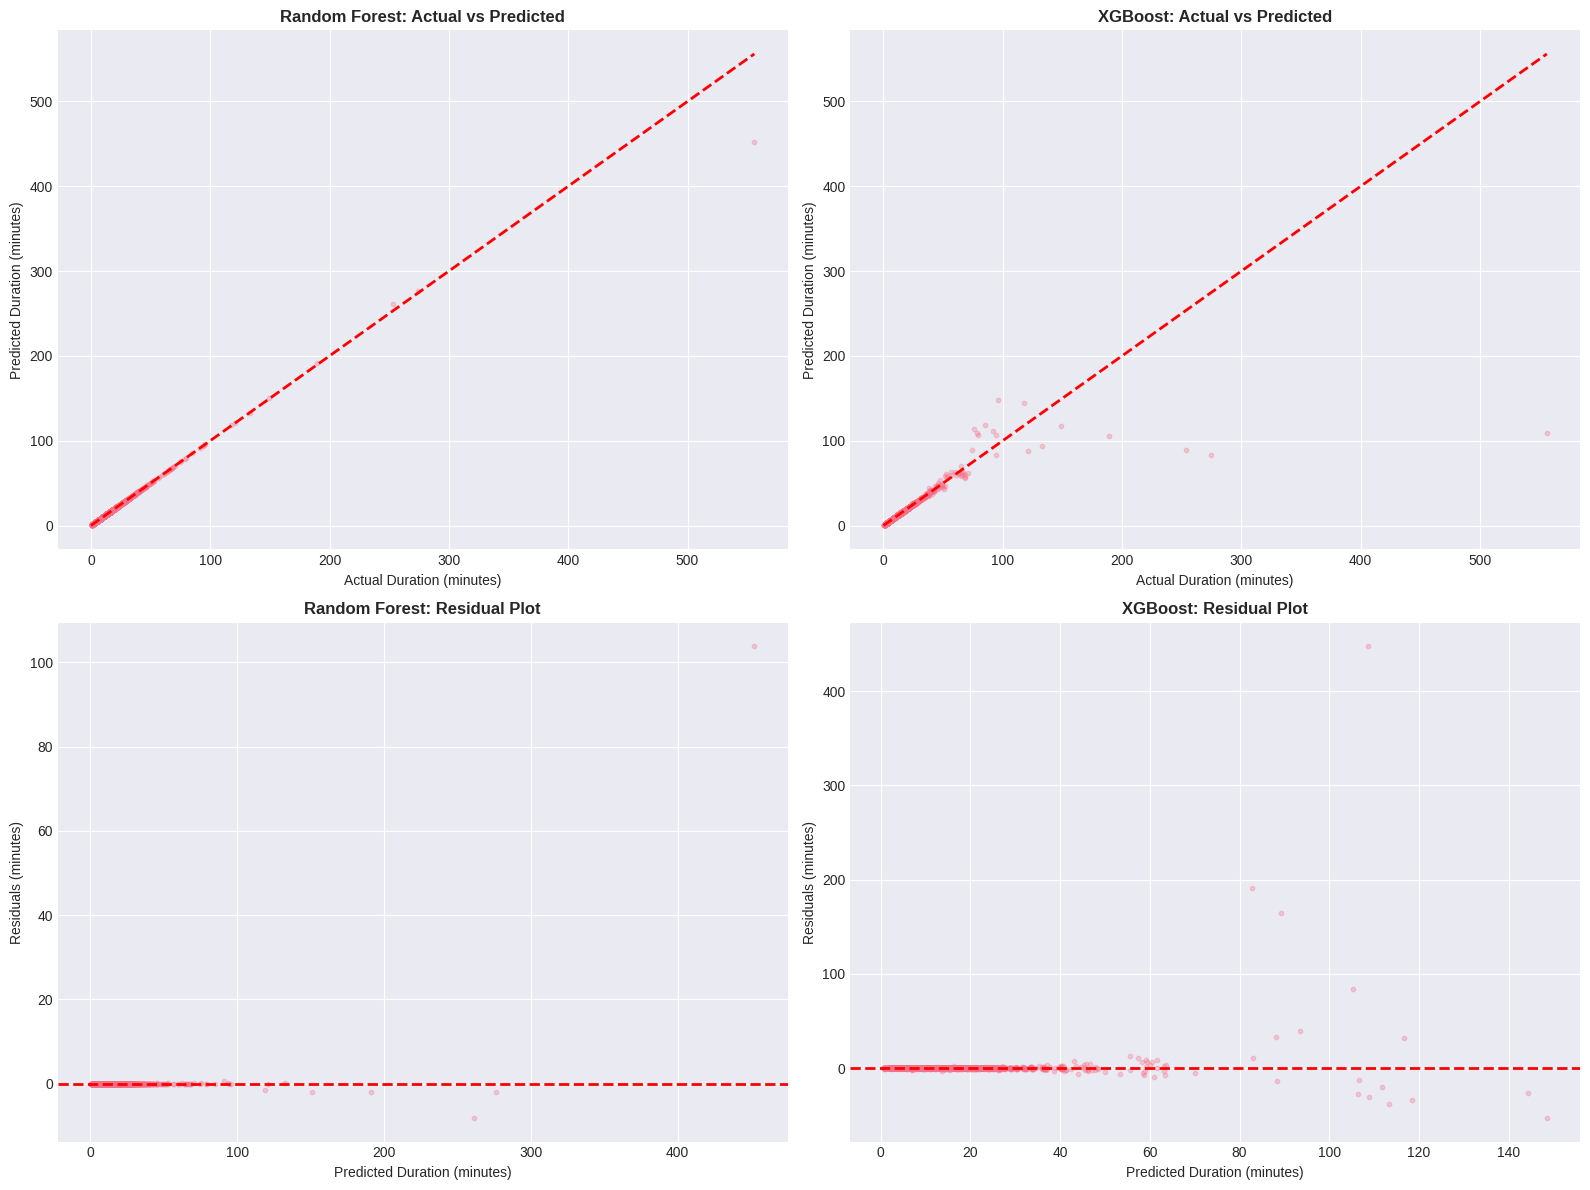


✓ Prediction visualization completed!


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Actual vs Predicted (Random Forest)
sample_size = min(5000, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)

axes[0, 0].scatter(y_test.iloc[sample_indices]/60,
                   y_pred_rf_test[sample_indices]/60,
                   alpha=0.3, s=10)
axes[0, 0].plot([0, y_test.max()/60], [0, y_test.max()/60], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Duration (minutes)')
axes[0, 0].set_ylabel('Predicted Duration (minutes)')
axes[0, 0].set_title('Random Forest: Actual vs Predicted', fontweight='bold')

# 2. Actual vs Predicted (XGBoost)
axes[0, 1].scatter(y_test.iloc[sample_indices]/60,
                   y_pred_xgb_test[sample_indices]/60,
                   alpha=0.3, s=10)
axes[0, 1].plot([0, y_test.max()/60], [0, y_test.max()/60], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Duration (minutes)')
axes[0, 1].set_ylabel('Predicted Duration (minutes)')
axes[0, 1].set_title('XGBoost: Actual vs Predicted', fontweight='bold')

# 3. Residuals (Random Forest)
residuals_rf = (y_test.iloc[sample_indices] - y_pred_rf_test[sample_indices]) / 60
axes[1, 0].scatter(y_pred_rf_test[sample_indices]/60, residuals_rf, alpha=0.3, s=10)
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Duration (minutes)')
axes[1, 0].set_ylabel('Residuals (minutes)')
axes[1, 0].set_title('Random Forest: Residual Plot', fontweight='bold')

# 4. Residuals (XGBoost)
residuals_xgb = (y_test.iloc[sample_indices] - y_pred_xgb_test[sample_indices]) / 60
axes[1, 1].scatter(y_pred_xgb_test[sample_indices]/60, residuals_xgb, alpha=0.3, s=10)
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted Duration (minutes)')
axes[1, 1].set_ylabel('Residuals (minutes)')
axes[1, 1].set_title('XGBoost: Residual Plot', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Prediction visualization completed!")

In [15]:
print("\n" + "="*80)
print("SAVING MODELS AND PREPROCESSORS")
print("="*80)

# Save Random Forest model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("✓ Random Forest model saved: random_forest_model.pkl")

# Save XGBoost model
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("✓ XGBoost model saved: xgboost_model.pkl")

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler saved: scaler.pkl")

# Save K-Means models
with open('kmeans_start.pkl', 'wb') as f:
    pickle.dump(kmeans_start, f)
print("✓ Start cluster model saved: kmeans_start.pkl")

with open('kmeans_end.pkl', 'wb') as f:
    pickle.dump(kmeans_end, f)
print("✓ End cluster model saved: kmeans_end.pkl")

# Save feature columns
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)
print("✓ Feature columns saved: feature_columns.pkl")

# Save a sample of processed data for testing
sample_data = df.sample(min(1000, len(df)))
sample_data.to_csv('sample_trips.csv', index=False)
print("✓ Sample data saved: sample_trips.csv")

print("\n✓ All models and preprocessors saved successfully!")

# Download files
print("\nDownloading model files...")
files.download('random_forest_model.pkl')
files.download('xgboost_model.pkl')
files.download('scaler.pkl')
files.download('kmeans_start.pkl')
files.download('kmeans_end.pkl')
files.download('feature_columns.pkl')
files.download('sample_trips.csv')


SAVING MODELS AND PREPROCESSORS
✓ Random Forest model saved: random_forest_model.pkl
✓ XGBoost model saved: xgboost_model.pkl
✓ Scaler saved: scaler.pkl
✓ Start cluster model saved: kmeans_start.pkl
✓ End cluster model saved: kmeans_end.pkl
✓ Feature columns saved: feature_columns.pkl
✓ Sample data saved: sample_trips.csv

✓ All models and preprocessors saved successfully!



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>